In [1]:
%matplotlib inline

from cv2 import cv2
from matplotlib import pyplot as plt
import numpy as np
import re
import yaml
import math
import os

plt.rcParams['figure.figsize'] = [13, 7]

In [2]:
def get_images(path):
    '''
    Функция возвращает список ссылок на все изображения в папке path
    '''
    return [path + x for x in os.listdir(path) if x.endswith('.png')]

In [3]:
# опасный момент
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [4]:
def readYAMLFile(file):
    ret = {}
    skip_lines = 1    # Skip the first line which says "%YAML:1.0". Or replace it with "%YAML 1.0"
    with open(file) as fin:
        for i in range(skip_lines):
            fin.readline()
        yamlFileOut = fin.read()
        myRe = re.compile(r":([^ ])")   # Add space after ":", if it doesn't exist. Python yaml requirement
        yamlFileOut = myRe.sub(r': \1', yamlFileOut)
        ret = yaml.safe_load(yamlFileOut)
    return ret

In [5]:
class Image:
    def __init__(self, path):
        self.id = path[path.index('frame'): -4]
        self.path = path
        self.image = cv2.imread(path, cv2.IMREAD_COLOR)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    
    
    def add_boxes(self, path):
        self.boxes = readYAMLFile(path)['boxes']
    
    
    # очевидный недочет: объект sift инициализируется при каждом вызове функции
    def get_sift_features(self, type_='coords'):
        '''
        Функция применяет на изображении алгоритм SIFT 
        и по умолчанию возвращает массив координат точек
        При вводе аргумента type_ = 'keypoints' возвращает массив элементов типа KeyPoint
        '''
        
        sift = cv2.SIFT_create()
        kp = sift.detect(self.gray, None)
        # self.sift_kp = kp
        
        if type_ == 'keypoints':
            return kp
        
        else:
            #return [x.pt for x in kp]
            return cv2.KeyPoint_convert(kp)
        
        
    def get_harris_features(self):
        '''
        Функция применяет на изображении алгоритм Harris Corner
        и возвращает массив координат точек.
        '''
        dst = cv2.cornerHarris(self.gray, 2, 3, 0.04)
        dst = cv2.dilate(dst, None)

        # переписать этот кошмар...
        inner_image = self.image.copy()
        inner_image[dst > 0.01 * dst.max()] = [0, 255, 0]
        coord = np.where(np.all(inner_image == (0, 255, 0), axis=-1))
        #                (x, y)
        return np.array([[b, a] for a, b in zip(coord[0], coord[1])], dtype='float32')
        
    
    def get_gftt_features(self):
        '''
        Функция применяет на изображении алгоритм GoodFeaturesToTrack
        и возвращает массив координат точек.
        '''
        
        # shi-tomasi parameters
        feature_params = dict(
                               maxCorners = 100,
                               qualityLevel = 0.3,
                               minDistance = 7,
                               blockSize = 7)
        
        
        # обязательно ли дальше придерживаться такой записи? array[[[x1, y1]], [[x2, y2]]]
        features = cv2.goodFeaturesToTrack(self.gray, mask = None, **feature_params)  
        return features.reshape(len(features), 2) # =corners
     
    # написано для использования в юпитере!
    def plot(self, features=np.array([False])): # plot(self, gray=False, keypoints=None):
        '''
        Функция отрисовывает изображение
        '''
        
        plt.rcParams['figure.figsize'] = [13, 7]
        
        #if gray == True:
        #    image = self.gray.copy()
        #    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #    plt.imshow(image, cmap = plt.cm.gray)
        #    plt.show()
        
        #else:
        #    image = self.image.copy()
         
        image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)  
            
        if features.any(): 
            #image = cv2.drawKeypoints(image, keypoints, image) - встроенная отрисовка KeyPoint'ов
            features = [[normal_round(y) for y in x] for x in features]
            
            # неоптимально?
            for keypoint in features:
                # (x, y)
                image = cv2.circle(image, keypoint, 2, [0, 255, 0], 1)
            
        plt.imshow(image)
        plt.show()
        
    
    def box_check_features(self, features, type_='list'):
        '''
        Функция проверяет точки из списка features на предмет попадания в bounding box'ы, 
        если для кадра таковые имеются.
        '''
        
        verified_d = dict()
        features_boxed = list()

        for obj in self.boxes:
            verified_d[obj['id']] = []

            for point in features:
                if obj['x_min'] < point[0] < obj['x_max'] and obj['y_min'] < point[1] < obj['y_max']:
                    verified_d[obj['id']].append(point)
                    features_boxed.append(point)
        
        if type_ == 'dict':
            return verified_d
        else:
            return np.array(features_boxed)

### 

In [6]:
imgs_path = 'images/cam0/'
images = get_images(imgs_path)

print(images[5])

images/cam0/frame-10251.png


In [16]:
demo = Image(images[5])

sift_feat = demo.get_sift_features()
hc_feat = demo.get_harris_features()
gftt_feat = demo.get_gftt_features()

demo.add_boxes('frames/cam0/frame_10251.yml')

print(f'''
    SIFT до филтрации: {len(sift_feat)} После: {len(demo.box_check_features(sift_feat))}
    Harris Corner фильтрации: {len(hc_feat)} После: {len(demo.box_check_features(hc_feat))}
    GFTT до: {len(gftt_feat)} После: {len(demo.box_check_features(gftt_feat))}
''')



#demo.plot(sift_feat)
#demo.plot(hc_feat)
#demo.plot(gftt_feat)


    SIFT до ограничения боксами: 351 После: 208
    Harris Corner до ограничения боксами: 2299 После: 1722
    GFTT до ограничения боксами: 18 После: 14



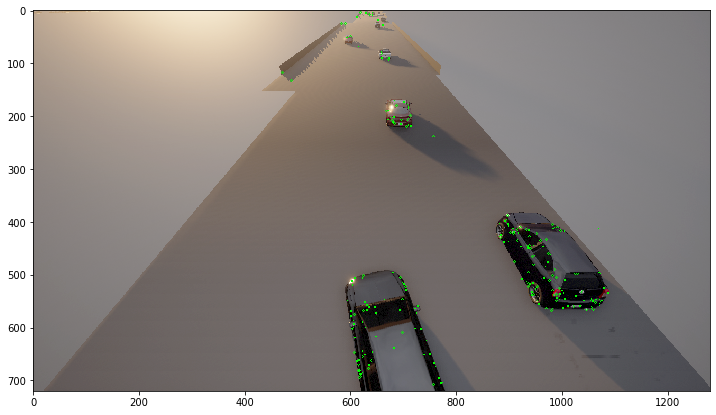

In [18]:
demo.plot(sift_feat)

In [ ]:
#for path in images:
#    image = Image(path)
#    print(f'''
#    {image.id}
#    Sift: {len(image.get_sift_features())} features
#    Harris Corner: {len(image.get_harris_features())} features
#    GFTT: {len(image.get_gftt_features())} features
#    ''')